# <center> Pandemic Watching

In [1]:
#importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from pprint import pprint
import numpy as np
import scipy.stats as st
from config import m_api_key
from config import t_api_key

In [2]:
# Creating Dataframe of Netflix Movies  ( based out of www.flixable.com)
df = pd.read_csv('flixable_df.csv')
df.head()

,Unnamed: 0,date,link,title,description,href,rating
0,0,January 29,https://flixable.com/title/below-zero/,Below Zero,2021,https://www.imdb.com/title/tt4016994/?ref_=tt_...,7.5/10
1,1,January 29,https://flixable.com/title/finding-ohana/,Finding ‘Ohana,2021,https://www.imdb.com/title/tt10332588/?ref_=tt...,6.1/10
2,2,January 29,https://flixable.com/title/the-dig/,The Dig,2021,https://www.imdb.com/title/tt3661210/?ref_=tt_...,7.2/10
3,3,January 29,https://flixable.com/title/we-are-the-brooklyn...,We Are: The Brooklyn...,2021,https://www.imdb.com/title/tt3661210/?ref_=tt_...,7.2/10
4,4,January 28,https://flixable.com/title/june-kopi/,June & Kopi,2021,https://www.imdb.com/title/tt13728764/?ref_=tt...,6.8/10


In [3]:
#extracting list of movies released in 2019 and 2020 
movie19 = df.loc[df['description']==2019,'title']
movie20 = df.loc[df['description']==2020,'title']
print(f'Total number of movies in 2019 are {len(movie19)}')
print(f'Total number of movies in 2020 are {len(movie20)}')

Total number of movies in 2019 are 972
Total number of movies in 2020 are 877


### Creating functions 

In [4]:
def movie_id(movie_list):#-------------- need to optimise the query-----------------------
    tmdb_df = pd.read_json('movie_ids_02_01_2021.json',lines = True)
#     tmdb_df = pd.read_json('movie_ids_02_01_2021.json',lines = True)
    
    tmdb_df.rename(columns = {'original_title': 'title'},inplace = True)
    tmdb_df.set_index('title')
    id_df = pd.merge(tmdb_df, movie19, how='inner', on = 'title')
    imdb_id = []
    name = []
    revenue = []
    c= 0
    for ids in id_df['id']:
        try:
            
            target_url = f'https://api.themoviedb.org/3/movie/{ids}?api_key={t_api_key}'
            response = requests.get(target_url)
            data = response.json()
    #         pprint(data)
            imdb_id.append(data['imdb_id'])
            name.append(data['title'])
            revenue.append(data['revenue'])
            print(f'Revenue found for tmdb id {ids}')
            c+=1
        except:
            print(f'No revenue data found for tmdb id {ids} ')

    revenue_df  = pd.DataFrame({'Title': name, 'MovieID': imdb_id, 'revenue':revenue})
    print(f'----------------------------------------------------------------------------\n Revenue Data extracted successfully for {c} movies\n----------------------------------------------------------------------------')
    return (revenue_df)
            


def fetch_db (movies):
    title = []
    genre = []
    lang = []
    idx = []
    irating = []
    ivotes = []
    year = []
    count = 0
    print('--------------------------------------\nExtracting Data from OMDB\n--------------------------------------')
    for each_movie in movies:
        url = f"http://www.omdbapi.com/?t={each_movie}&apikey={m_api_key}" 
#         print(url)
        try:

            response = requests.get(url)
            data = response.json()
            title.append(data['Title'])
            ivotes.append(data['imdbVotes'])
            irating.append(data['imdbRating'])
            idx.append(data['imdbID'])
            genre.append(data['Genre'].split(','))
            print(f'Movie: {each_movie} check')
        except:
            print(f'Movie: {each_movie}  details not found')
            count+=1
   
    movie_df = pd.DataFrame({'MovieID':idx, 'Title': title, 'Votes':ivotes, 'Rating': irating, 'Genre': genre})
    print(f'--------------------------------------\nTotal Movies in the Database  :  {len(movie_df)}      \n--------------------------------------\nTotal Missing Movies  :  {count}      \n--------------------------------------')

    return(movie_df)


def outlier(df,col):
    q1 = np.quantile(df[col],0.25) 
    q3 = np.quantile(df[col],0.75)
    IQR = q3 - q1
    upbound = q3+(1.5* IQR)
    lowbound = q1-(1.5*IQR)
    fig1, ax1 = plt.subplots()
    ax1.boxplot(df[col],  sym = 'r', showmeans = True)
    plt.show()   

    #dropping the outliers
    for idx, srs in df.iterrows():
        if srs[col]<lowbound:
            df = df.drop(index = idx)
        if srs[col]>upbound:
            df = df.drop(index = idx)
    plt.show() 
    print(f'---------------------- After dropping Outliers----------------------')
    print(f'-----------------------Final Data Points = {len(df)}----------------------')
    df.hist()
    plt.show() 
    

def regress(x,y,nx,ny):
    slope, inter, r, p, std = st.linregress(x,y)
    x_axis_19 = np.arange(max(x))
    y_pred_19 = slope*x_axis_19 +inter
    plt.plot(x_axis_19,y_pred_19, c='r')
    print(f'r is {r} and p is {p}')
    plt.annotate(f'y = {round(slope,4)}x + {round(inter,2)} ', (nx,ny), c= 'r',fontsize = 10)
    plt.show()
    
def rating_votes(df, gen):
    v_count=0
    r_count=0
    rev_count = 0
    new_r_gen = []
    new_r_gen = gen
    for genre in gen['Genre']:
        for idx , srs in df.iterrows():
            for g in srs['Genre']:
                if g == genre:
                    v_count+=srs['Votes']/100000
                    r_count+=srs['Rating']
        new_r_gen.loc[new_r_gen['Genre'] == genre,'Votes']=v_count
        new_r_gen.loc[new_r_gen['Genre'] == genre,'Rating']= r_count
        
        v_count=0
        r_count=0
        return(gen)
        
def genre_revenue(df,gen):
    rev_count = 0
    new_gen = gen
    for genre in gen['Genre']:
        for idx , srs in df.iterrows():
            for g in srs['Genre']:
                if g == genre:
                    rev_count +=srs['revenue']
        new_gen.loc[new_gen['Genre']==genre,'revenue']= rev_count
        rev_count = 0
        return(new_gen)
    

# 2019 movies Database

In [5]:
#calling all the 2019 movies on Netflix by pinging the OMDB API
movie19_df = fetch_db(movie19)

--------------------------------------
Extracting Data from OMDB
--------------------------------------
Movie: Hire a Woman check
Movie: She Is check
Movie: Demon Slayer: Kimetsu... check
Movie: Pinkfong & Baby Shark's... check
Movie: Al acecho check
Movie: L.A.’s Finest  details not found
Movie: QB1: Beyond the Lights check
Movie: The Creative Brain check
Movie: Too Handsome to Handle  details not found
Movie: Dare Me check
Movie: Sakho & Mangane check
Movie: Isa Pa with Feelings check
Movie: Bridezilla check
Movie: Hello, Love, Goodbye check
Movie: Mohamed Hussein  details not found
Movie: Diamond City check
Movie: Jeopardy! check
Movie: Eggnoid: Love & Time... check
Movie: Sakaling Maging Tayo check
Movie: The Wedding Shaman  details not found
Movie: The Professor and the... check
Movie: The Panti Sisters check
Movie: Kalel, 15 check
Movie: Once Upon a Time check
Movie: Juman check
Movie: Between Maybes check
Movie: Rust Creek check
Movie: Spookley and the... check
Movie: 40 Sticks 

Movie: Playing with Fire check
Movie: KD (A) Karuppudurai check
Movie: Motichoor Chaknachoor check
Movie: Tiny House Nation check
Movie: Booba check
Movie: Deadcon check
Movie: Jezebel check
Movie: NiNoKuni check
Movie: Eye For An Eye check
Movie: The Brave check
Movie: Women of Mafia 2 check
Movie: Made in China check
Movie: Giri / Haji check
Movie: Anne with an E check
Movie: Thieves of the Wood check
Movie: Chhota Bheem Kung Fu... check
Movie: Luccas Neto in...  details not found
Movie: Aaviri check
Movie: Albert Pinto Ko Gussa... check
Movie: ARASHI's Diary -Voyage- check
Movie: Benchwarmers 2... check
Movie: Good Girls check
Movie: How High 2 check
Movie: Occupied check
Movie: The Degenerates check
Movie: The Neighbor check
Movie: Yanxi Palace: Princess... check
Movie: The Disastrous Life of... check
Movie: Hot Gimmick: Girl Meets... check
Movie: Kevin Hart: Don’t F**k...  details not found
Movie: The Secret Life of Pets 2 check
Movie: The App check
Movie: The Bonfire of Destiny c

Movie: Rhythm + Flow check
Movie: Deon Cole: Cole Hearted check
Movie: The Spooky Tale of... check
Movie: Legend Quest: Masters... check
Movie: My Country: The New Age check
Movie: Noblemen check
Movie: Brother in Love check
Movie: Creeped Out check
Movie: In the Tall Grass check
Movie: Kids on the Block check
Movie: Peaky Blinders check
Movie: Raising Dion check
Movie: Rotten check
Movie: Super Monsters check
Movie: Super Monsters: Vida's... check
Movie: Seis Manos check
Movie: Living Undocumented check
Movie: Ready to Mingle check
Movie: Little Baby Bum: Go Buster  details not found
Movie: Nikki Glaser: Bangin’ check
Movie: Gotham check
Movie: Mo Gilligan: Momentum check
Movie: Cultivating the Seas...  details not found
Movie: Domino check
Movie: TUNA GIRL check
Movie: Bard of Blood check
Movie: El Marginal check
Movie: In the Shadow of the Moon check
Movie: Skylines check
Movie: Sturgill Simpson... check
Movie: Explained check
Movie: Malaal check
Movie: Abstract: The Art of... check

Movie: Bad Blood  details not found
Movie: Chopsticks  details not found
Movie: Killer Ratings  details not found
Movie: Mere Pyare Prime Minister  details not found
Movie: Pegasus  details not found
Movie: When They See Us  details not found
Movie: Svaha: The Sixth Finger  details not found
Movie: Historical Roasts  details not found
Movie: After Maria  details not found
Movie: Joy  details not found
Movie: Rim of the World  details not found
Movie: The Perfection  details not found
Movie: WHAT / IF  details not found
Movie: The Lonely Island...  details not found
Movie: A Tale of Two Kitchens  details not found
Movie: Wanda Sykes: Not Normal  details not found
Movie: Prince of Peoria  details not found
Movie: 1994  details not found
Movie: It's Bruno!  details not found
Movie: Maria  details not found
Movie: ReMastered: The Lion's...  details not found
Movie: Saverio Raimondo: Il...  details not found
Movie: See You Yesterday  details not found
Movie: White Gold  details not found
Mo

In [6]:
revenue_df = movie_id(movie19)

No revenue data found for tmdb id 187 
No revenue data found for tmdb id 742121 
No revenue data found for tmdb id 327 
No revenue data found for tmdb id 173274 
No revenue data found for tmdb id 356501 
No revenue data found for tmdb id 524114 
No revenue data found for tmdb id 681960 
No revenue data found for tmdb id 720122 
No revenue data found for tmdb id 754869 
No revenue data found for tmdb id 441 
No revenue data found for tmdb id 300972 
No revenue data found for tmdb id 576692 
No revenue data found for tmdb id 624841 
No revenue data found for tmdb id 797 
No revenue data found for tmdb id 659481 
No revenue data found for tmdb id 667999 
No revenue data found for tmdb id 675776 
No revenue data found for tmdb id 741572 
No revenue data found for tmdb id 1976 
No revenue data found for tmdb id 576704 
No revenue data found for tmdb id 688034 
No revenue data found for tmdb id 2157 
No revenue data found for tmdb id 577902 
No revenue data found for tmdb id 620244 
No reven

No revenue data found for tmdb id 214159 
No revenue data found for tmdb id 266544 
No revenue data found for tmdb id 382811 
No revenue data found for tmdb id 405477 
No revenue data found for tmdb id 442909 
No revenue data found for tmdb id 494379 
No revenue data found for tmdb id 495511 
No revenue data found for tmdb id 557307 
No revenue data found for tmdb id 557372 
No revenue data found for tmdb id 663191 
No revenue data found for tmdb id 670752 
No revenue data found for tmdb id 674801 
No revenue data found for tmdb id 689255 
No revenue data found for tmdb id 690814 
No revenue data found for tmdb id 715367 
No revenue data found for tmdb id 742691 
No revenue data found for tmdb id 759649 
No revenue data found for tmdb id 38920 
No revenue data found for tmdb id 107781 
No revenue data found for tmdb id 168534 
No revenue data found for tmdb id 706305 
No revenue data found for tmdb id 39172 
No revenue data found for tmdb id 117705 
No revenue data found for tmdb id 11

No revenue data found for tmdb id 218974 
No revenue data found for tmdb id 236048 
No revenue data found for tmdb id 283974 
No revenue data found for tmdb id 287638 
No revenue data found for tmdb id 437958 
No revenue data found for tmdb id 472344 
No revenue data found for tmdb id 508591 
No revenue data found for tmdb id 543466 
No revenue data found for tmdb id 567706 
No revenue data found for tmdb id 589362 
No revenue data found for tmdb id 644409 
No revenue data found for tmdb id 654042 
No revenue data found for tmdb id 709429 
No revenue data found for tmdb id 764199 
No revenue data found for tmdb id 108256 
No revenue data found for tmdb id 602609 
No revenue data found for tmdb id 109841 
No revenue data found for tmdb id 478258 
No revenue data found for tmdb id 112205 
No revenue data found for tmdb id 231384 
No revenue data found for tmdb id 403693 
No revenue data found for tmdb id 406561 
No revenue data found for tmdb id 444500 
No revenue data found for tmdb id 

No revenue data found for tmdb id 465003 
No revenue data found for tmdb id 467185 
No revenue data found for tmdb id 504118 
No revenue data found for tmdb id 581475 
No revenue data found for tmdb id 586521 
No revenue data found for tmdb id 715746 
No revenue data found for tmdb id 473033 
No revenue data found for tmdb id 473584 
No revenue data found for tmdb id 522246 
No revenue data found for tmdb id 474399 
No revenue data found for tmdb id 618827 
No revenue data found for tmdb id 483351 
No revenue data found for tmdb id 591486 
No revenue data found for tmdb id 488145 
No revenue data found for tmdb id 582607 
No revenue data found for tmdb id 492188 
No revenue data found for tmdb id 743770 
No revenue data found for tmdb id 500682 
No revenue data found for tmdb id 519129 
No revenue data found for tmdb id 504859 
No revenue data found for tmdb id 567392 
No revenue data found for tmdb id 505929 
No revenue data found for tmdb id 505948 
No revenue data found for tmdb id 

In [11]:
revenue_df

,Title,MovieID,revenue


In [12]:
movie19_df

,MovieID,Title,Votes,Rating,Genre
0,tt10279104,Hire a Woman,7,5.7,"[Comedy, Romance]"
1,tt1527731,She Is,8,8.1,"[Short, Adventure, Drama, Musical, Romance]"
2,tt9335498,Demon Slayer: Kimetsu No Yaiba,"23,929",8.7,"[Animation, Action, Fantasy, Thriller]"
3,tt9854932,Pinkfong Wonderstar,10,7.1,[Animation]
4,tt11287390,Al Acecho,118,5.1,[Thriller]
...,...,...,...,...,...
545,tt0298856,Evelyn,"6,290",7.0,[Drama]
546,tt10095336,Our Godfather,"1,261",6.8,[Documentary]
547,tt9428190,Norm of the North: King Sized Adventure,311,3.3,"[Animation, Adventure, Comedy, Family]"
548,tt10324144,Article 15,"23,428",8.2,"[Crime, Drama, Mystery, Thriller]"


In [24]:

rev_db = pd.merge(movie19_df,revenue_df,how = 'inner', on = ['Title','MovieID'])
revenue_df.set_index('Title')
revenue_df.head(100)
# a small smaple of data is present which has information on revenue. But the sample size is suffiecient for representing the data
rev_db = rev_db[rev_db['revenue']!=0]
print(len(rev_db))


0


In [25]:
revenue_df

,Title,MovieID,revenue


In [26]:
movie19_db = movie19_df

In [27]:

# cleaning up the data
movie19_db['Votes'].replace(',','', regex=True, inplace=True)
movie19_db['Rating'].replace(',','', regex=True, inplace=True)
# remove commas from votes and ratings
movie19_db['Votes'] = movie19_db['Votes'].apply(pd.to_numeric, downcast='float', errors='coerce')
movie19_db['Rating'] = movie19_db['Rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
# convert to float for numeric calculation

In [28]:
movie19_db.dtypes

MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
dtype: object

In [29]:
#Dropping rows with null value
movie19_db.dropna(inplace=True)
len(movie19_db) # total value = 871

541

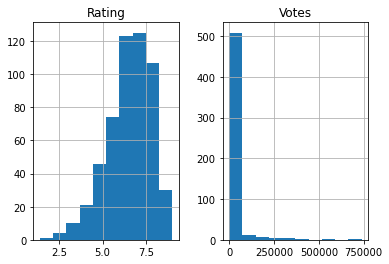

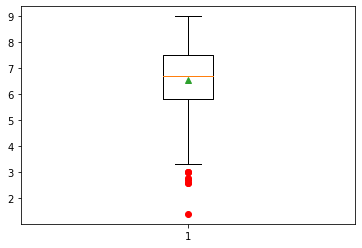

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 533----------------------


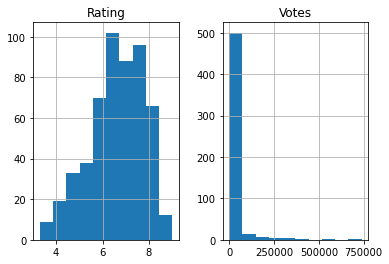

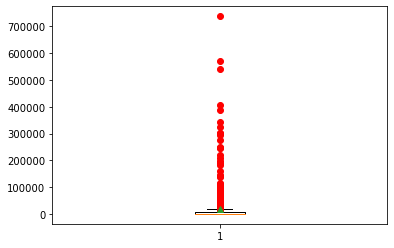

---------------------- After dropping Outliers----------------------
-----------------------Final Data Points = 459----------------------


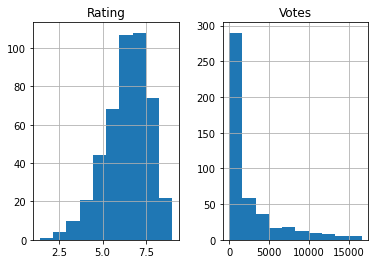

In [30]:
# understanding the Movie Ratings and Votes Data
#Shape of data
movie19_db.hist()

# Identifying and removing Outliers from Ratings
outlier(movie19_db, 'Rating')
outlier(movie19_db, 'Votes')
    
# movie ratings are now somewhat normally distributed   

In [31]:
new_genre = []
for i in movie19_db['Genre']:
    for j in i:
        new_genre.append(j.strip())
genre19_list = np.unique(new_genre)
genre19_list.sort()
genre19_list
genre19_df = pd.DataFrame({'Genre':genre19_list})
genre19_df
# row #17 list N/A as a Genre which needs to be removed
genre19_df = genre19_df.drop(index=17)
genre19_df

,Genre
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


In [32]:
final_rev_df = genre_revenue(rev_db,genre19_df)
# final_rev_df.drop(index = [1,6,8,9,10,11,12,15,16,18,19,20,21,22,23,24,25,26], inplace = True)#--------------------- how not to hard code
final_rev_df
# final_rev_df.plot('Genre','revenue',kind = 'bar')

,Genre,revenue
0,Action,0.0
1,Adventure,NaN
2,Animation,NaN
3,Biography,NaN
4,Comedy,NaN
5,Crime,NaN
6,Documentary,NaN
7,Drama,NaN
8,Family,NaN
9,Fantasy,NaN


In [33]:

rating_votes(movie19_db, genre19_df)


genre19_df

,Genre,revenue,Votes,Rating
0,Action,0.0,27.14246,337.200001
1,Adventure,NaN,NaN,NaN
2,Animation,NaN,NaN,NaN
3,Biography,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN
5,Crime,NaN,NaN,NaN
6,Documentary,NaN,NaN,NaN
7,Drama,NaN,NaN,NaN
8,Family,NaN,NaN,NaN
9,Fantasy,NaN,NaN,NaN


In [34]:
#dropping empty genre Musical, Talk Show, War, Film Noir
genre19_df.drop(index=[10,15,23,25], inplace = True)

print(len(genre19_df))

KeyError: '[25] not found in axis'

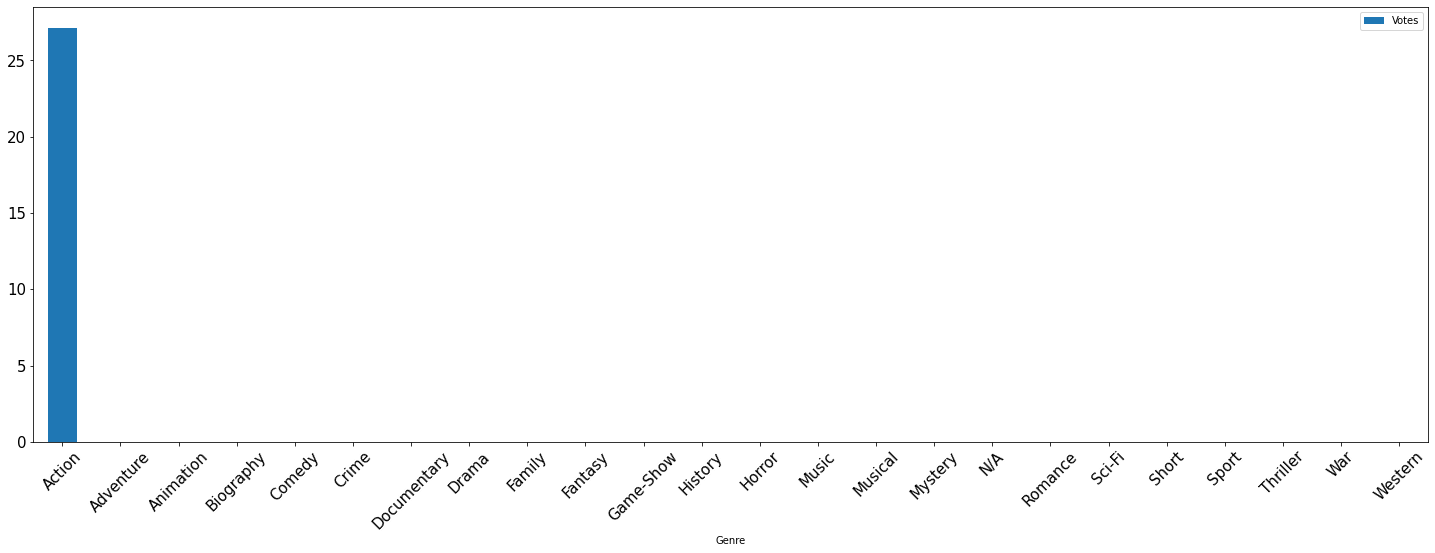

In [43]:
# Genre VS Votes Plot - 2019
genre19_df.plot('Genre', 'Votes', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

###  <jusitfy>The plot shows that for the year 2019, comedy was the most voted Genre. The number of votes may also be treated as an indirect indicator of the number of views of a given genre, as the data for exact number of views is not freely available.
### Keeping this in mind, one can safely say that 'Comedy' was the most viewed genre of 2019

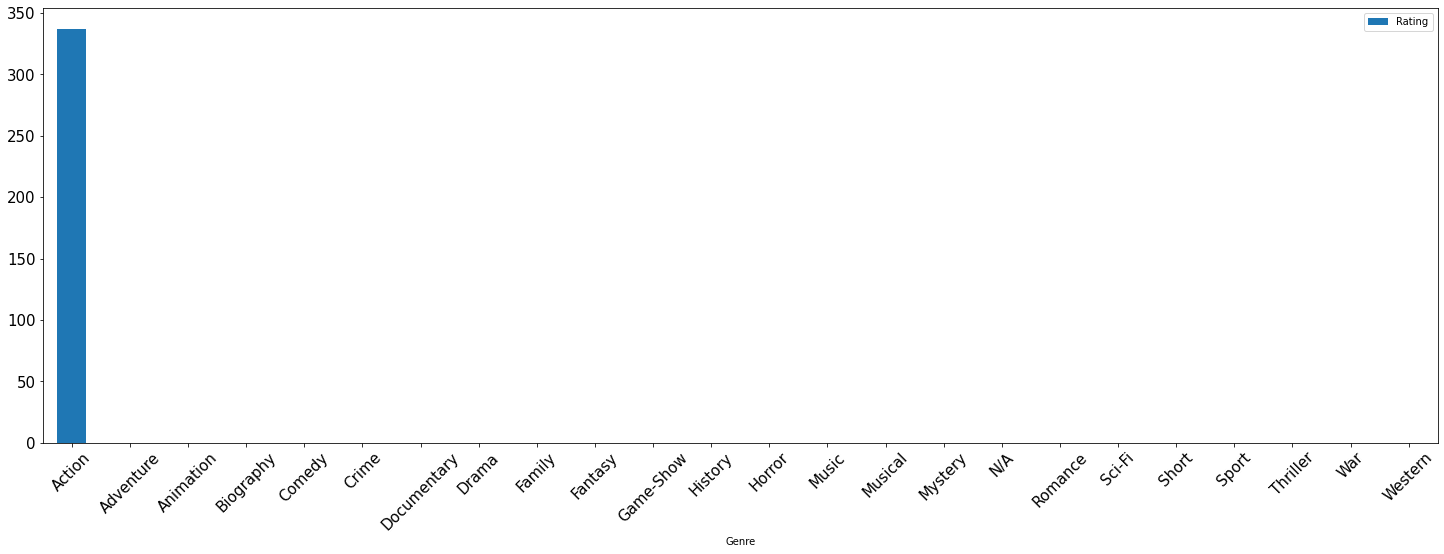

In [44]:
genre19_df.plot('Genre', 'Rating', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

### The plot shows that for the year 2019, comedy was the highest rated Genre. The ratings of the genre may also be treated as an indirect indicator of the number of views of a given genre, as the data for exact number of views is not freely available.
### Keeping this in mind, one can safely say that 'Comedy' was the most viewed genre of 2019

C:\Users\cpoir\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


r is nan and p is nan


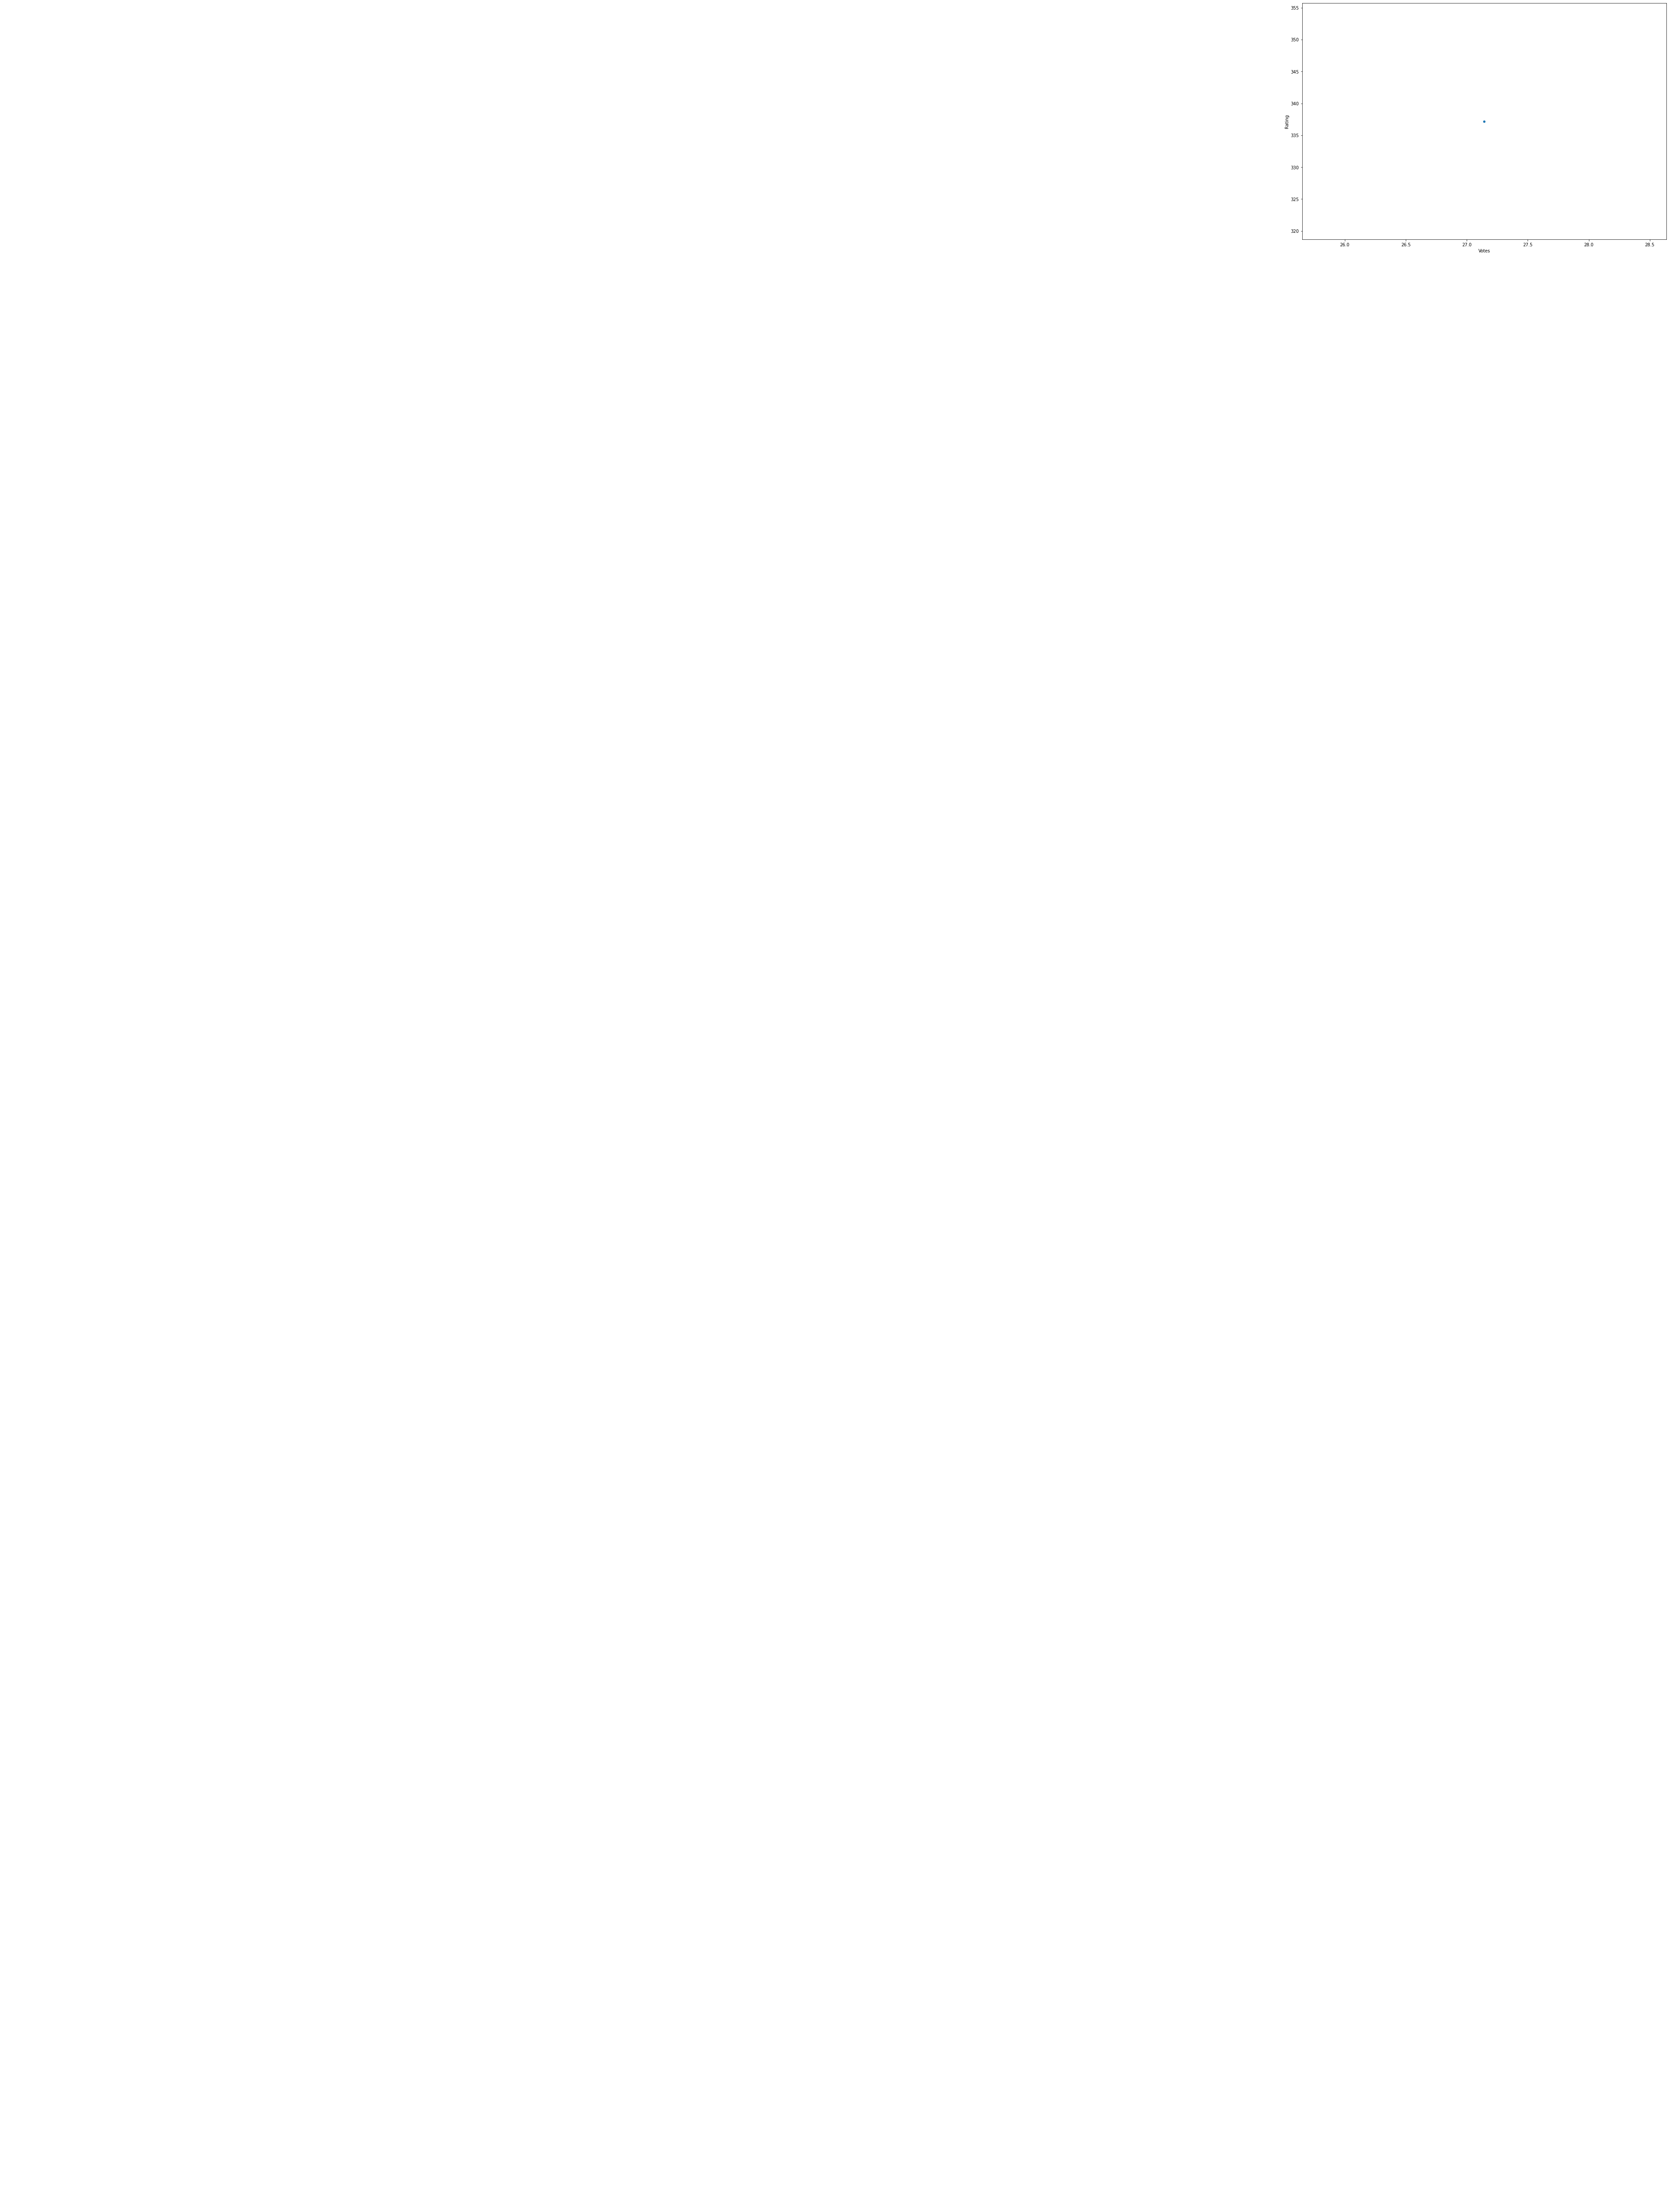

In [45]:
#---------------- to be discussed with Kevin-----------------------------------
genre19_df.plot('Votes','Rating', kind = 'scatter', figsize = (15,10), fontsize = 10)
x = genre19_df['Votes']
y = genre19_df['Rating']
nx = 15
ny = 10
regress(x,y, nx, ny)


# 2020 Movies Database


In [39]:

movie20_db = fetch_db(movie20)


--------------------------------------
Extracting Data from OMDB
--------------------------------------
Movie: Accomplice check
Movie: Kilometers and Kilometers check
Movie: So My Grandma’s a Lesbian! check
Movie: Friendsgiving check
Movie: The Shadow of Violence  details not found
Movie: Cut Throat City check
Movie: Sightless check
Movie: Death of Me check
Movie: Double Dad check
Movie: The Magicians check
Movie: The Vanished check
Movie: The Heartbreak Club check
Movie: Last Tango in Halifax check
Movie: 100% Halal check
Movie: Pieces of a Woman check
Movie: Tony Parker: The Final... check
Movie: Korean Pork Belly Rhapsody  details not found
Movie: Asphalt Burning check
Movie: Full Out 2: You Got This! check
Movie: Running Man check
Movie: Best of Stand-Up 2020 check
Movie: Chilling Adventures of... check
Movie: Tarung Sarung check
Movie: Best Leftovers Ever! check
Movie: Equinox check
Movie: Gameboys Level-Up Edition  details not found
Movie: SanPa: Sins of the Savior check
Movie: T

Movie: David Attenborough: A... check
Movie: Best Wishes, Warmest... check
Movie: Schitt's Creek check
Movie: A Go! Go! Cory Carson... check
Movie: Dick Johnson Is Dead check
Movie: Emily in Paris check
Movie: Òlòtūré check
Movie: Serious Men check
Movie: The Binding check
Movie: Vampires vs. the Bronx check
Movie: You've Got This check
Movie: All Because of You check
Movie: Good Morning, Verônica check
Movie: Oktoberfest: Beer & Blood check
Movie: The Book of Sun  details not found
Movie: The Outpost check
Movie: The Worst Witch check
Movie: You Cannot Hide check
Movie: American Murder: The... check
Movie: Man with a Plan check
Movie: The Boys in the Band check
Movie: The Boys in the Band... check
Movie: Wentworth check
Movie: Michelle Buteau... check
Movie: Welcome to Sudden Death check
Movie: Whose Vote Counts... check
Movie: The Good Place check
Movie: A Perfect Crime check
Movie: Mighty Little Bheem check
Movie: Sneakerheads check
Movie: The Great British... check
Movie: The Schoo

Movie: Nobody Knows I'm Here check
Movie: Eric Andre: Legalize... check
Movie: Roswell, New Mexico check
Movie: Kappela check
Movie: It's Okay to Not Be Okay check
Movie: Babies check
Movie: Chaman Bahaar check
Movie: Disclosure check
Movie: Feel the Beat check
Movie: Floor Is Lava check
Movie: Lost Bullet check
Movie: Most Beautiful Thing check
Movie: One-Way to Tomorrow check
Movie: Rhyme Time Town check
Movie: The Politician check
Movie: Wasp Network check
Movie: A Whisker Away check
Movie: El límite infinito check
Movie: One Take check
Movie: The Order check
Movie: Riding Faith check
Movie: Alexa & Katie check
Movie: Asura Guru check
Movie: How to Get Away with... check
Movie: Milea check
Movie: Axone check
Movie: Da 5 Bloods check
Movie: Dating Around check
Movie: F is for Family check
Movie: Frank Elstner: Just One... check
Movie: Jo Koy: In His Elements check
Movie: The Search check
Movie: The Woods check
Movie: Whispers check
Movie: Curon check
Movie: DC's Legends of Tomorrow c

Movie: Taj Mahal 1989 check
Movie: Love Is Blind check
Movie: Narcos: Mexico check
Movie: To All the Boys: P.S. I... check
Movie: Captain Underpants Epic... check
Movie: ROAD TO ROMA check
Movie: Dragons: Rescue Riders check
Movie: Horse Girl check
Movie: Locke & Key check
Movie: My Holo Love check
Movie: Who Killed Malcolm X? check
Movie: Cagaster of an Insect Cage check
Movie: #cats_the_mewvie  details not found
Movie: The Pharmacist check
Movie: Uppity: The Willy T... check
Movie: Dragonheart: Vengeance check
Movie: Tom Papa: You're Doing... check
Movie: Team Kaylie check
Movie: The Silent War check
Movie: Itaewon Class check
Movie: Night on Earth: Shot in... check
Movie: 37 Seconds check
Movie: Diablero check
Movie: I AM A KILLER check
Movie: Luna Nera check
Movie: Miss Americana check
Movie: Ragnarok check
Movie: Unauthorized Living check
Movie: THE STRANGER check
Movie: What the Love! with... check
Movie: Find Yourself check
Movie: Next in Fashion check
Movie: Night on Earth chec

In [40]:
movie20_db

,MovieID,Title,Votes,Rating,Genre
0,tt0038285,Accomplice,133,5.4,"[Film-Noir, Mystery, Thriller]"
1,tt7268736,Kilometers and Kilometers,703,6.3,"[Adventure, Comedy, Drama]"
2,tt9695258,So My Grandma's a Lesbian!,43,5.7,[Comedy]
3,tt8431078,Friendsgiving,758,4.2,"[Comedy, Drama]"
4,tt3547306,Cut Throat City,"1,201",4.8,"[Action, Crime, Drama, Thriller]"
...,...,...,...,...,...
820,tt9117054,Spinning Out,"9,879",7.7,"[Drama, Sport]"
821,tt4287320,The Circle,"84,386",5.3,"[Drama, Sci-Fi, Thriller]"
822,tt3986586,Fuller House,"24,723",6.8,"[Comedy, Family]"
823,tt11168104,Maradona in Mexico,890,7.2,"[Documentary, Comedy, Drama, Sport]"


In [41]:

# cleaning up the data
movie20_db['Votes'].replace(',','', regex=True, inplace=True)
movie20_db['Rating'].replace(',','', regex=True, inplace=True)
# remove commas from votes and ratings
movie20_db['Votes'] = movie19_db['Votes'].apply(pd.to_numeric, downcast='float', errors='coerce')
movie20_db['Rating'] = movie19_db['Rating'].apply(pd.to_numeric, downcast='float', errors='coerce')
# convert to float for numeric calculation

In [42]:
movie20_db.dtypes


MovieID     object
Title       object
Votes      float64
Rating     float64
Genre       object
dtype: object

In [ ]:
#Dropping rows with null value
movie20_db.dropna(inplace=True)
len(movie20_db)

In [ ]:
# understanding the Movie Ratings and Votes Data
#Shape of data
movie20_db.hist()

# Identifying and removing Outliers from Ratings
outlier(movie20_db, 'Rating')
outlier(movie20_db, 'Votes')
    
# movie ratings are now somewhat normally distributed  

In [ ]:
new_genre = []
for i in movie20_db['Genre']:
    for j in i:
        new_genre.append(j.strip())
    
genre20_list = np.unique(new_genre)
genre20_list.sort()
genre20_list
genre20_df = pd.DataFrame({'Genre':genre20_list})
genre20_df #25 different genre
# row #17 list N/A as a Genre which needs to be removed
genre20_df = genre20_df.drop(index=17)
genre20_df

In [ ]:
rating_votes(movie20_db, genre20_df)
genre20_df

In [ ]:
#dropping empty genre Musical, Mystery, News, Sci-Fi, Sport, War, Western
genre20_df.drop(index=[15,16,18,21,23,26,27], inplace = True)

print(len(genre20_df))

In [ ]:
# Genre VS Votes Plot - 2020
genre20_df.plot('Genre', 'Votes', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

In [ ]:
# Genre VS Rating Plot - 2020
genre20_df.plot('Genre', 'Rating', rot = 45, kind = 'bar', figsize = (25,8), fontsize = 15)

In [ ]:
# fig, ax = plt.subplots()----------------------------to be discussed with Kevin
# size = 4
# x = genre_df['Genre']
# y1= genre_df['Votes']
# y2 = genre_df['Rating']

# cmap = plt.get_cmap("tab20c")
# outer_colors = cmap(np.arange(3)*4)
# inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

# ax.pie(y1, radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'), labels=x)

# ax.pie(y2, radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'), labels = x)

# plt.title='Votes VS Rating'
# plt.show()


In [ ]:
#---------------- to be discussed with Kevin-----------------------------------
genre20_df.plot('Votes','Rating', kind = 'scatter', figsize = (15,10), fontsize = 10)
x = genre20_df['Votes']
y = genre20_df['Rating']
nx = 15000
ny = 1000
regress(x,y, nx, ny)

In [ ]:
# t test means of ratings and votes of 2019 & 2020 